In [67]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Union, List

DATA_FILEPATH = "../data/raw/Bloomberg ETFs Cleaned.xlsx"

In [68]:
rawData_df = pd.read_excel(DATA_FILEPATH, sheet_name='all_etf', index_col=0, parse_dates=True)
rawData_df.columns = [x.split()[0] for x in rawData_df.columns]
rawData_df

,SPY,VTI,VXUS,ACWI,EEM,AGG,BND,GOVT,LQD,BNDX
Date,,,,,,,,,,
1994-01-03,46.4688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-04,46.6563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-05,46.7500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-06,46.7500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-07,47.0313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-10-11,579.5800,286.11,64.110,120.16,46.36,99.50,73.82,23.020,110.81,49.94
2024-10-14,584.3200,288.34,64.145,120.78,46.17,99.41,73.77,23.000,110.82,49.94
2024-10-15,579.7800,286.36,63.130,119.52,45.19,99.81,74.06,23.095,111.36,50.09


<Axes: title={'center': 'GOVT Price Time Series'}, xlabel='Date'>

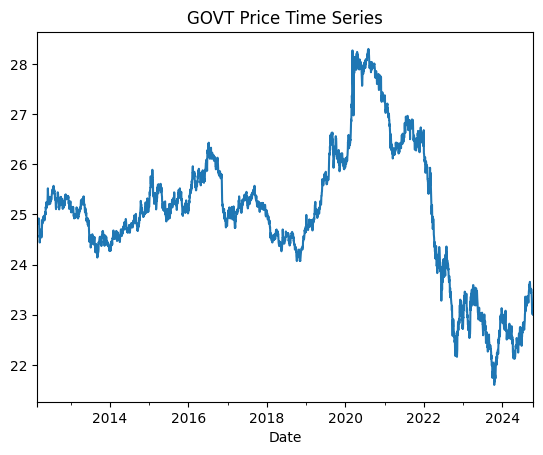

In [69]:
rawData_df['GOVT'].dropna().plot(title='GOVT Price Time Series')

In [70]:
rets = rawData_df.pct_change()
rets['GOVT'].mean()

np.float64(-1.8458214426818442e-05)

In [71]:
# do sma (periods)
# Run on our raw data
# Choose one EQUITY / FI -> 60/40 portfolio -> returns
# rerun on sma model to get performance metrics (mean, vol, sharpe)

# 11 stocks + 3 broad etf (GOLD, HYG, TIPS) -> run on sma individually get performane metrics ( mean vol sharpe) then rank
# correlation of matrix of above with  60/40 portfolio
# we add each into the original portfolio 80 / 20 new asset -> run sma again -> get metrics (mean vol sharpe) -> rank by sharpe
# Compare individual sharpe ranking vs portfolio sharpe -->

In [72]:
# Assuming that the input data is daily, window is rolling window for sma, period_factor is for annualization
# returns the sma returns df and the summary stats (Mean, Vol, Sharpe)
def get_sma_performance(rets,  window=20, annual_factor=252, var_quantile: Union[float, List] = .05):
    returns = rets.dropna().rolling(window=window).mean().dropna()
    
    summary_statistics = pd.DataFrame(index=returns.columns)
    summary_statistics['Mean'] = returns.mean()
    summary_statistics['Annualized Mean'] = returns.mean() * annual_factor
    summary_statistics['Vol'] = returns.std()
    summary_statistics['Annualized Vol'] = returns.std() * np.sqrt(annual_factor)
    ### To check for r.f.r.
    summary_statistics['Sharpe'] = returns.mean() / returns.std()
    summary_statistics['Annualized Sharpe'] = summary_statistics['Sharpe'] * np.sqrt(annual_factor)
    summary_statistics['Min'] = returns.min()
    summary_statistics['Max'] = returns.max()
    summary_statistics['Skewness'] = returns.skew()
    summary_statistics['Excess Kurtosis'] = returns.kurtosis()
    var_quantile = [var_quantile] if isinstance(var_quantile, (float, int)) else var_quantile
    for var_q in var_quantile:
        summary_statistics[f'Historical VaR ({var_q:.2%})'] = returns.quantile(var_q, axis = 0)
        summary_statistics[f'Annualized Historical VaR ({var_q:.2%})'] = returns.quantile(var_q, axis = 0) * np.sqrt(annual_factor)
        summary_statistics[f'Historical CVaR ({var_q:.2%})'] = returns[returns <= returns.quantile(var_q, axis = 0)].mean()
        summary_statistics[f'Annualized Historical CVaR ({var_q:.2%})'] = returns[returns <= returns.quantile(var_q, axis = 0)].mean() * np.sqrt(annual_factor)
    
    wealth_index = 1000 * (1 + returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary_statistics['Max Drawdown'] = drawdowns.min()
    summary_statistics['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_statistics['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_statistics['Recovery'] = recovery_date
    try:
        summary_statistics["Duration (days)"] = [
            (i - j).days if i != "-" else "-" for i, j in
            zip(summary_statistics["Recovery"], summary_statistics["Bottom"])
        ]
    except (AttributeError, TypeError) as e:
        print(f'Cannot calculate "Drawdown Duration" calculation because there was no recovery or because index are not dates: {str(e)}')

    return returns, summary_statistics

sma_rets, summary_stats = get_sma_performance(rets[['SPY', 'AGG']], window=20, annual_factor=252)
summary_stats


,Mean,Annualized Mean,Vol,Annualized Vol,Sharpe,Annualized Sharpe,Min,Max,Skewness,Excess Kurtosis,Historical VaR (5.00%),Annualized Historical VaR (5.00%),Historical CVaR (5.00%),Annualized Historical CVaR (5.00%),Max Drawdown,Peak,Bottom,Recovery,Duration (days)
SPY,0.000380,0.095826,0.002185,0.034686,0.174029,2.762628,-0.017362,0.012284,-1.492428,8.722784,-0.003247,-0.051538,-0.005494,-0.087217,-0.469562,2007-10-18,2009-03-17,2011-05-11,785.0
AGG,0.000003,0.000768,0.000628,0.009967,0.004856,0.077083,-0.006606,0.004811,-0.256512,6.988101,-0.001024,-0.016260,-0.001498,-0.023773,-0.217505,2020-08-12,2023-10-31,NaT,NaN


<font color='red'>

#### 60/40 Portfolio performance - SPY/BNDX

</font>

In [85]:
og_pf_rets = rets[['SPY', 'AGG']].dropna()
og_pf_weight = pd.DataFrame(index=['SPY', 'AGG'], columns=['Weights'])
og_pf_weight.loc['SPY', 'Weights'] = 0.6
og_pf_weight.loc['AGG', 'Weights'] = 0.4
og_pf_rets = og_pf_rets @ og_pf_weight
og_pf_rets.rename(columns={'Weights': '60/40 (SPY/BNDX)'}, inplace=True)
og_pf_rets_sma, summary_stats = get_sma_performance(og_pf_rets, window=20, annual_factor=252)
summary_stats

,Mean,Annualized Mean,Vol,Annualized Vol,Sharpe,Annualized Sharpe,Min,Max,Skewness,Excess Kurtosis,Historical VaR (5.00%),Annualized Historical VaR (5.00%),Historical CVaR (5.00%),Annualized Historical CVaR (5.00%),Max Drawdown,Peak,Bottom,Recovery,Duration (days)
60/40 (SPY/BNDX),0.000229,0.057803,0.001384,0.021978,0.165676,2.630029,-0.012831,0.008413,-1.55243,10.481465,-0.002003,-0.031801,-0.003465,-0.055002,-0.311769,2007-10-31,2009-03-17,2011-02-01,686


<font color='red'>

#### Do similar analysis to 11 stocks (1 from each sector) and 3 Broad Market ETFs ()

</font>

<font color='red'>

#### Include each stock in the original portfolio, 80/20 (48 Equity / 32 FI / 20 addition)

</font>